#### Building a Decision Tree

Building a classification decision tree or a regression decision tree is very similar when it comes to the way we organise the input data and predictor variables. Then, by calling the corresponding functions, the classification decision tree or regression decision tree will be automatically created for us. Of course, we have to specify some criteria which are simple conditions.

The main steps to build a decision tree are:

1. Retrieve the market data for a financial instrument.
2. Introduce the predictor variables (i.e. Technical indicators, Sentiment indicators, Breadth indicators, etc.).
3. Setup the target variable or the desired output.
4. Split the data between training and test data.
5. Generate the decision tree after training the model.
6. Test and analyse the model.

If we look at the first four steps, they are common operations for data processing.

Steps 5 and 6 are related to the ML algorithms for the decision trees specifically. As we will see, the implementation in Python will be quite simple. However, it is fundamental to understand well the parameterisation and the analysis of the results. 

#### Getting the Data

The raw material for any algorithm is data. In our case, it would be the time series of financial instruments, such as indices, stocks, etc. and it usually contains details like the opening price, maximum, minimum, closing price and volume. 

There are multiple data sources to download the data, free and premium. The most common sources for free daily data are Quandl, Yahoo, Google, or any other data source we trust.

For the sake of uniformity, we are going to use the same dataset which we used in the previous part of the book. This helps us because we don't need to spend time on getting the data, but rather, we can focus on the machine learning algorithm and its working.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Technical indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

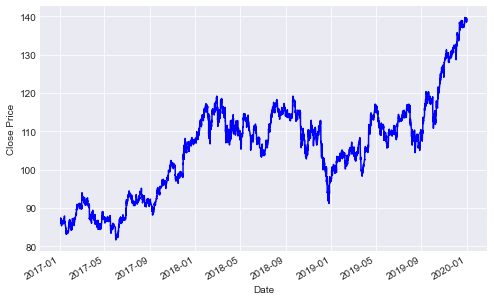

In [2]:
# The data is stored in the directory 'data_modules'
path = "../data_modules/"

# Read the data
data = pd.read_csv(path + 'JPM_2017_2019.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data.close.plot(figsize=(8,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

In [3]:
import sys
sys.path.append("..")

from data_modules.utility import get_target_features
y, X = get_target_features(data)

split = int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], \
y[:split], y[split:]

## Decision Trees for Classification

Now let’s create the classification decision tree using the DecisionTreeClassifier function from the sklearn.tree library.

Although the DecisionTreeClassifier function has many parameters that we invite you to know and experiment with (help(DecisionTreeClassifier)), here we will see the basics to create the classification decision tree.

``` Python
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3, 
                       max_features=None, max_leaf_nodes=None,
                       min_samples_leaf=5, min_samples_split=2, 
                       min_weight_fraction_leaf=0.0, presort=False, 
                       random_state=None, splitter='best')

```

Basically, refer to the parameters with which the algorithm must build the tree because it follows a recursive approach to build the tree, so we must set some limits to create it.

<b>criterion</b>: For the classification decision trees, we can choose Gini or Entropy and Information Gain, these criteria refer to the loss function to evaluate the performance of a  machine learning algorithm, and are the most used when it comes to the classification algorithms. Although it is beyond the scope of this chapter, it serves us to adjust the accuracy of the model, and the algorithm to build the tree. It also stops evaluating the branches in which no improvement is obtained according to the loss function.

<b>max_depth</b>: Maximum number of levels the tree will have.

<b>min_samples_leaf</b>: This parameter is optimisable and indicates the minimum number of samples that we want to have in the leaves.

In [4]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=3,
                               min_samples_leaf=5)
model = model.fit(X_train, y_train)

Now we need to make forecasts with the model on unknown data. For this, we will use 30% of the data that we had kept reserved for testing, and finally, evaluate the performance of the model. But first, let’s take a graphical look at the classification decision tree that the ML algorithm has automatically created for us.

#### Visualise Decision Trees for Classification

We have at our disposal a very powerful tool that will help us to analyse graphically the tree that the ML algorithm has created automatically. The graph shows the most significant nodes that maximise the output and will help us determine, if applicable, some useful trading rules.

The graphviz library allows us to graph the tree that the `DecisionTreeClassifier` function has automatically created with the training data. You can use the conda forge command in the anaconda prompt to install it in your local system. Link: https://anaconda.org/conda-forge/python-graphviz

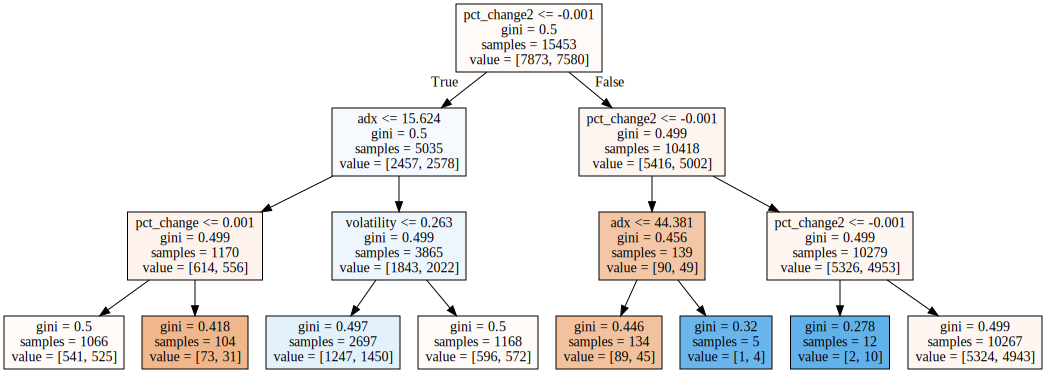

In [5]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(model, 
                                out_file=None,
                                filled=True,
                                feature_names=X_train.columns)
# To create the graph, you can uncomment 
# the below line of code and run it
graphviz.Source(dot_data)

Note that the graph only shows the most significant nodes. In this graph, we can see all the relevant information in each node:

1. The predictor variable used to split the data set.
2. The value of Gini impurity.
3. The number of data points available at that node.
4. The number of target variable data points belonging to each class, 1 and 0.

We can observe a pair of pure nodes that allows us to deduce possible trading rules. For example, you can see how the nodes are split depending on the feature values which the algorithm has given more preference to.

#### Forecast

Now let’s make predictions with data sets that were reserved for testing, this is the part that will let us know if the algorithm is reliable with unknown data in training.

In [6]:
predicted = model.predict(X_test)

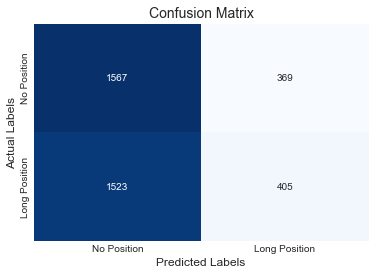

              precision    recall  f1-score   support

           0       0.51      0.81      0.62      1936
           1       0.52      0.21      0.30      1928

    accuracy                           0.51      3864
   macro avg       0.52      0.51      0.46      3864
weighted avg       0.52      0.51      0.46      3864



In [7]:
from data_modules.utility import get_metrics
get_metrics(y_test, predicted)

#### Performance Analysis

Finally, we can only evaluate the performance of the algorithm on unknown data by comparing it with the result obtained in the training process.

In [8]:
# Calculate the percentage change
strategy_data = X_test[['pct_change']].copy()

# Predict the signals
strategy_data['predicted_signal'] = model.predict(X_test)

# Calculate the strategy returns
strategy_data['strategy_returns'] = \
    strategy_data['predicted_signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,pct_change,predicted_signal,strategy_returns
2019-05-28 12:15:00+00:00,0.000732,0,0.0
2019-05-28 12:30:00+00:00,-0.000366,0,-0.0
2019-05-28 12:45:00+00:00,0.000366,0,0.0
2019-05-28 13:00:00+00:00,0.000091,0,0.0
2019-05-28 13:15:00+00:00,-0.000091,0,-0.0


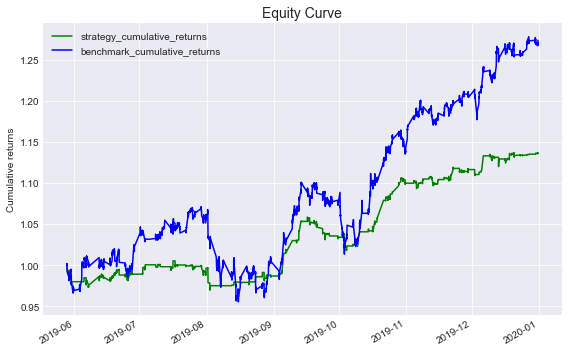

The maximum drawdown is -3.80%.


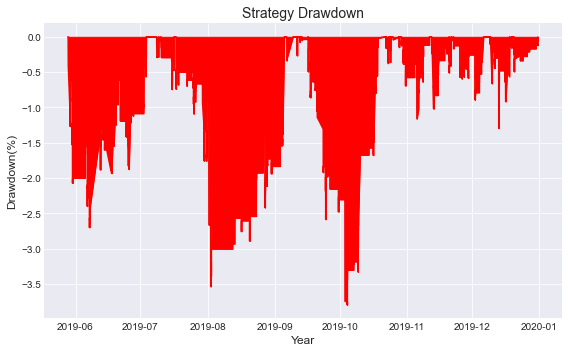

The Sharpe ratio is 2.46.


In [9]:
from data_modules.utility import get_performance
get_performance(strategy_data)

#### Decision Trees for Regression

Now let’s create the regression decision tree using the DecisionTreeRegressor function from the sklearn.tree library.

Although the DecisionTreeRegressor function has many parameters that we invite you to know and experiment with (help(DecisionTreeRegressor)), here we will see the basics to create the regression decision tree.

``` python
DecisionTreeRegressor(criterion='mse', max_depth=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None min_samples_leaf=400, 
                      min_samples_split=2, min_weight_fraction_leaf=0.0, 
                      presort=False, random_state=None, splitter='best')
```

Basically, refer to the parameters with which the algorithm must build the tree, because it follows a recursive approach to build the tree, we must set some limits to create it.

<b>Criterion</b>: For the classification decision trees, we can choose Mean Absolute Error (MAE) or Mean Square Error (MSE). These criteria are related with the loss function to evaluate the performance of a learning machine algorithm and are the most used for the regression algorithms. It basically serves us to adjust the accuracy of the model, the algorithm to build the tree, and stops evaluating the branches in which no improvement is obtained according to the loss function. Here, we left the default parameter to Mean Square Error (MSE).

<b>max_depth</b>: Maximum number of levels the tree will have. We have left it to the default parameter of 'none'.

<b>min_samples_leaf</b>: This parameter is optimisable and indicates the minimum number of leaves that we want the tree to have.

In [10]:
# Regression tree model
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 200)

Now we are going to train the model with the training datasets.

In [11]:
y = X['pct_change'].shift(-1)

split = int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], \
                                   y[:split], y[split:]

model = dtr.fit(X_train, y_train)

#### Visualise the Model

To visualise the tree, we again use the graphviz library that gives us an overview of the regression decision tree for analysis.

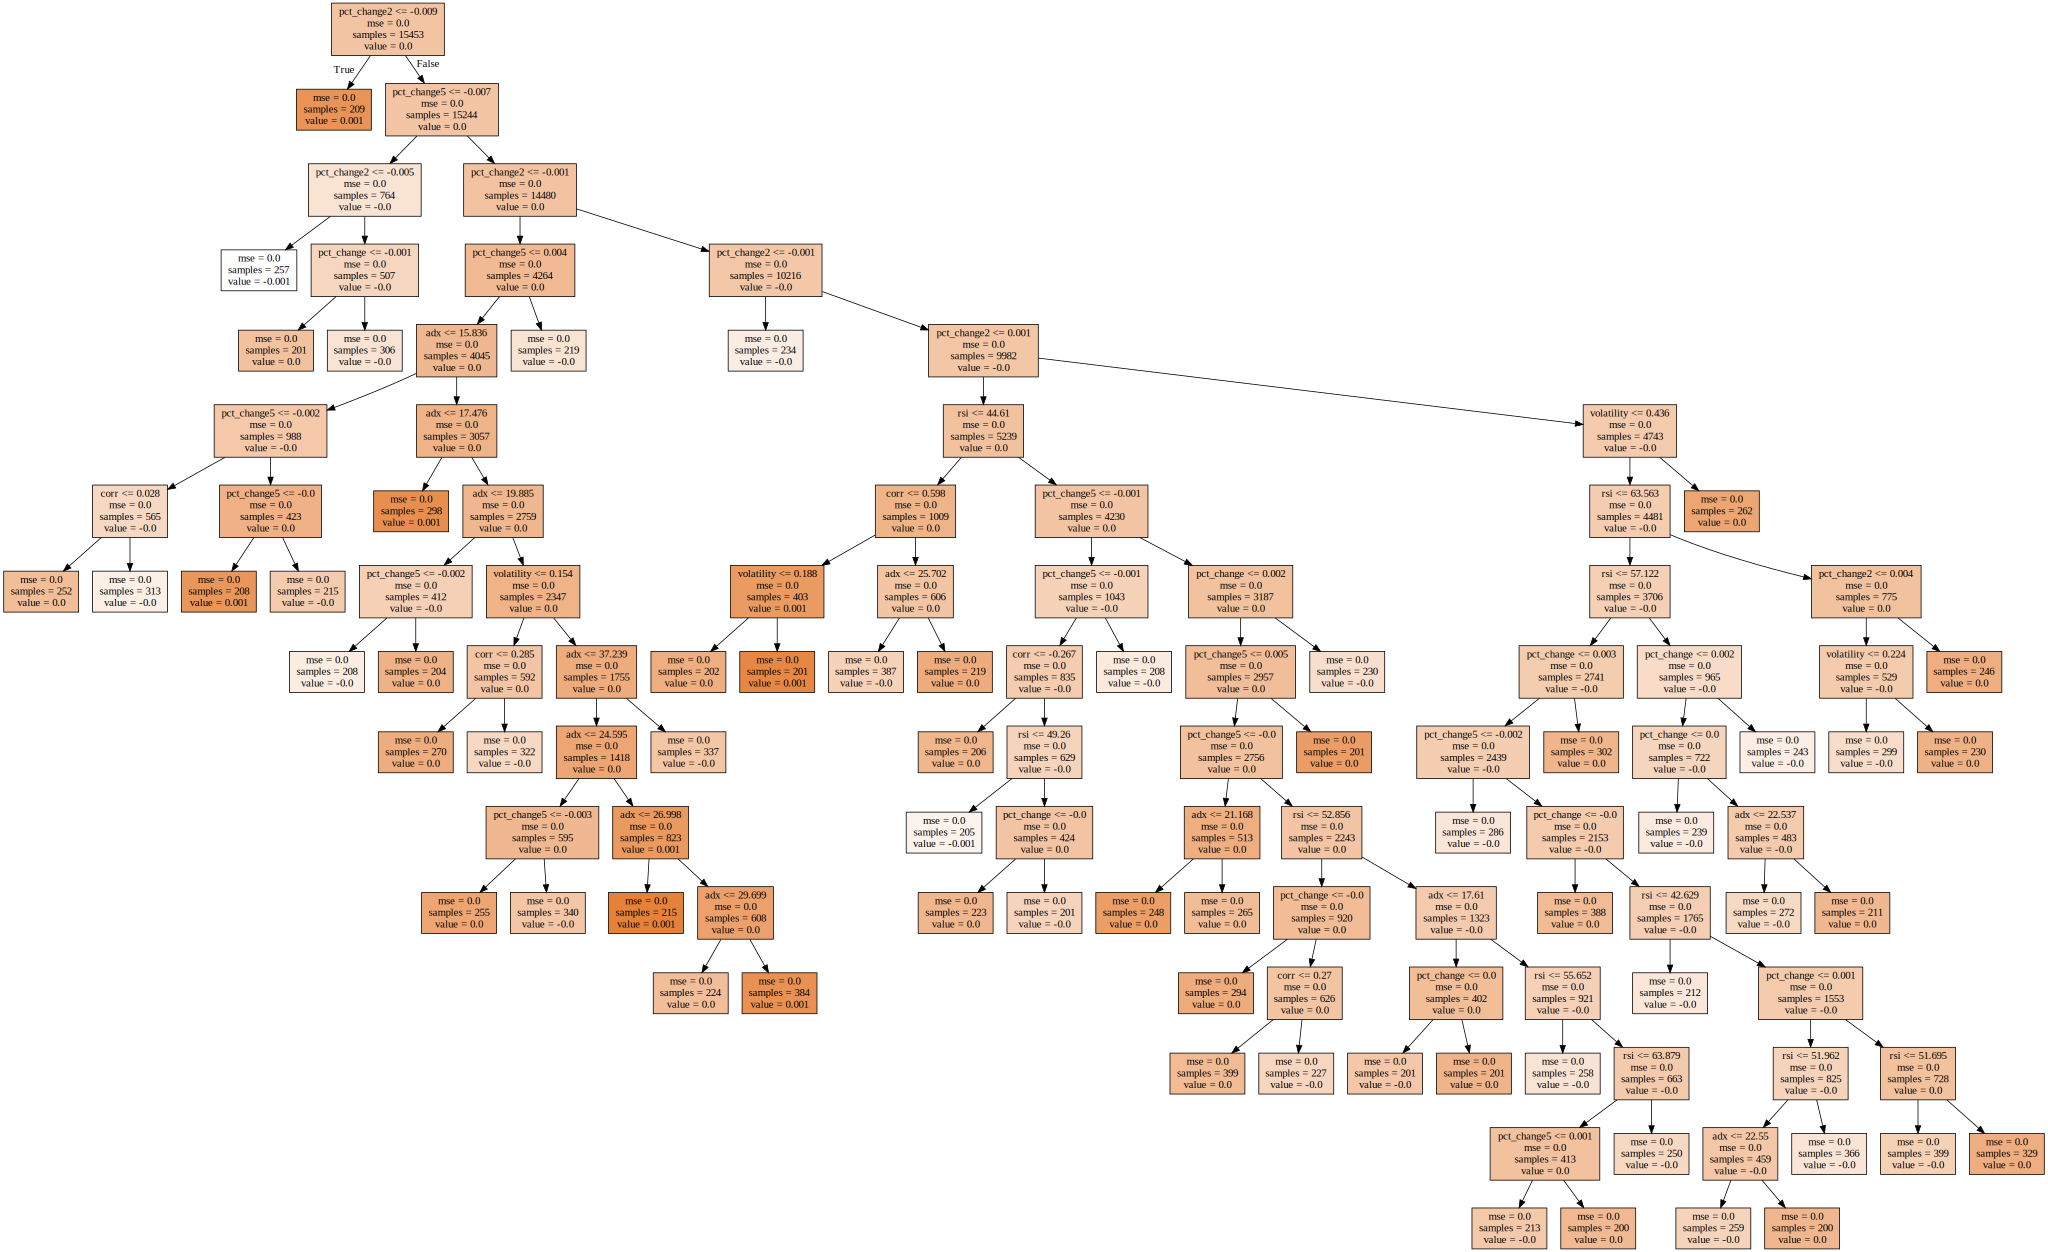

In [12]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr,
                  out_file=None,
                  filled=True,
                  feature_names=X_train.columns)
# To create the graph, you can uncomment 
# the below line of code and run it
graphviz.Source(dot_data)

In the graph, we can see all the relevant information in each node:

1. The predictor variable used to split the data set.
2. The value of MSE.
3. The number of data points available at that node

#### Conclusion

Decision trees are easy to create and it's easy to extract some rules that promise to be useful, but the truth is that to create decision trees, they need to be parametrised and these parameters can and must be optimised.

Sometimes, you can combine different models together to create an ensemble algorithm. There are two types of ensemble methods, mainly:

<b>Parallel Ensemble Methods or Averaging Methods</b><br>
Several models are created by one algorithm and the forecast is the average of the overall models. Some examples include:<br>

1. Bagging
2. Random Subspace
3. Random Forest

<b>Sequential Ensemble Methods or Boosting Methods</b>

The algorithm creates sequential models refining on each new model to reduce the bias of the previous one. The examples include<br>

1. AdaBoosting<br>
2. Gradient Boosting<br>